In [1]:
import numpy as np
import pandas as pd
import scipy.io
import scipy.interpolate
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from show_chanWeights import show_chanWeights
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn import metrics

In [2]:
filename1 = "feaSubEImg_1.csv"
filename2 = "feaSubEImg_2.csv"
filename3 = "feaSubEOvert_1.csv"
filename4 = "feaSubEOvert_2.csv"
filename5 = "sensors102.csv"

df_img1       = pd.read_csv(filename1, header = None)
df_img2       = pd.read_csv(filename2, header = None)
df_overt1     = pd.read_csv(filename3, header = None)
df_overt2     = pd.read_csv(filename4, header = None)
df_sensors102 = pd.read_csv(filename5, header = None)

In [3]:
img1       = df_img1.to_numpy()
img2       = df_img2.to_numpy()
overt1     = df_overt1.to_numpy()
overt2     = df_overt2.to_numpy()
sensors102 = df_sensors102.to_numpy()

print(img1.shape)
print(img2.shape)
print(overt1.shape)
print(overt2.shape)
print(sensors102.shape)

(204, 120)
(204, 120)
(204, 120)
(204, 120)
(102, 6)


In [4]:
# # Each trial (observation) is represented by a 204 * 1 vector
# print(img1[:, 0].shape)
# # Print out the first 5 feature values of the first trial 204 * 1 vector
# print(img1[0:5, 0])

# # The i-th feature vector is a 1 * 120 vector
# print(img1[0, :].shape)
# # Print out the first 5 trials of the first feature vector
# print(img1[0, 0:5])

In [5]:
# test_weights = np.linspace(1, 5, num = 5)
# chanVal = np.random.choice(a = test_weights, size = 204, 
#                            p = [0.30, 0.30, 0.30, 0.05, 0.05])
# print(chanVal.shape)
# print(chanVal[0:10])

In [6]:
# show_chanWeights(chanVal)

In [7]:
########################################################################

In [8]:
# X_img = np.concatenate((img1.T, img2.T))
# X_overt = np.concatenate((overt1.T, overt2.T))
# y_img = np.concatenate((-1 * np.ones(120), np.ones(120)))
# y_overt = np.concatenate((-1 * np.ones(120), np.ones(120)))
# print(X_img.shape)
# print(X_overt.shape)
# print(y_img.shape)
# print(y_overt.shape)

In [9]:
# from sklearn.svm import LinearSVC
# svm_img = LinearSVC(max_iter = 10000)
# svm_overt = LinearSVC(max_iter = 10000)
# svm_img.fit(X_img, y_img)
# testds = svm_img.decision_function(X_overt)
# print(testds.shape)

In [10]:
#####################################################################

In [11]:
def find_optimal_reg (accs, reg_type, reg_para) :
    best_i = 0
    best_j = 0 
    best_acc = accs[0, 0]
    for i in range(accs.shape[0]) :
        for j in range(accs.shape[1]) :
            if accs[i, j] > best_acc :
                best_i = i 
                best_j = j 
                best_acc = accs[i, j]
    best_reg_type = reg_type[best_i]
    best_reg_para = reg_para[best_j]
    # return best_i, best_j
    return best_reg_type, best_reg_para

In [12]:
def BCI_Decode (img1, img2) :
    X1 = np.copy(img1.T)
    X2 = np.copy(img2.T)
    y1 = (-1) * np.ones(X1.shape[0])
    y2 = (+1) * np.ones(X2.shape[0])
    cv1 = KFold(n_splits = 6, random_state = None, shuffle = False)
    cv2 = KFold(n_splits = 5, random_state = None, shuffle = False)
    reg_type = ["l1", "l2"]
    reg_para = np.array([0.01, 0.1, 1, 10, 100, 1000, 10000])
    cv1_ds = np.zeros((6, 40))
    cv1_acc = np.zeros(7)
    cv1_index = 0 
    cv1_fold1_weights = np.zeros(X1.shape[1])
    
    ###########################################################################################################
    for train_index, test_index in cv1.split(X1) :
        X1_train, X2_train = X1[train_index], X2[train_index]
        X1_test,  X2_test  = X1[test_index],  X2[test_index]
        y1_train, y2_train = y1[train_index], y2[train_index]
        y1_test,  y2_test  = y1[test_index],  y2[test_index]
        
        reg_cv2_acc = np.zeros((len(reg_type), reg_para.shape[0]))
        
        ############################################################################################
        for traincv2, testcv2 in cv2.split(X1_train) :
            X1_train_cv2, X2_train_cv2 = X1_train[traincv2], X2_train[traincv2]
            X1_test_cv2, X2_test_cv2   = X1_train[testcv2], X2_train[testcv2]
            y1_train_cv2, y2_train_cv2 = y1_train[traincv2], y2_train[traincv2]
            y1_test_cv2, y2_test_cv2   = y1_train[testcv2], y2_train[testcv2]
            X_train_cv2 = np.concatenate((X1_train_cv2, X2_train_cv2))
            X_test_cv2  = np.concatenate((X1_test_cv2, X2_test_cv2))
            y_train_cv2 = np.concatenate((y1_train_cv2, y2_train_cv2))
            y_test_cv2  = np.concatenate((y1_test_cv2, y1_test_cv2))
            
            for i in range(len(reg_type)) :
                for j in range(reg_para.shape[0]) :
                    svm_cv2 = LinearSVC(penalty = reg_type[i], C = reg_para[j], dual = False, max_iter = 10000)
                    svm_cv2.fit(X_train_cv2, y_train_cv2)
                    # print(svm_cv2.score(X_test_cv2, y_test_cv2))
                    reg_cv2_acc[i, j] += svm_cv2.score(X_test_cv2, y_test_cv2)
        #############################################################################################
        # print(reg_cv2_acc)
        
        best_type, best_para = find_optimal_reg(reg_cv2_acc, reg_type, reg_para)
        print("Current first level fold index is %i" % (cv1_index + 1))
        # print("Current optimal reg type is %s" % best_type)
        print("Current optimal regularization parameter is %.2f" % best_para)
        X_train_cv1 = np.concatenate((X1_train, X2_train))
        X_test_cv1  = np.concatenate((X1_test, X2_test))
        y_train_cv1 = np.concatenate((y1_train, y2_train))
        y_test_cv1  = np.concatenate((y1_test, y2_test))
        svm_cv1 = LinearSVC(penalty = best_type, C = best_para, dual = False, max_iter = 10000)
        svm_cv1.fit(X_train_cv1, y_train_cv1)
        cv1_ds[cv1_index, :] = svm_cv1.decision_function(X_test_cv1)
        cv1_acc[cv1_index] = svm_cv1.score(X_test_cv1, y_test_cv1)
        if cv1_index == 0 :
            cv1_fold1_weights = svm_cv1.coef_[0]
        cv1_index = cv1_index + 1 
    #############################################################################################################
    for k in range(6) :
        cv1_acc[6] = cv1_acc[6] + cv1_acc[k]
    cv1_acc[6] = float(cv1_acc[6]) / 6 
    
    return cv1_ds, cv1_acc, cv1_fold1_weights

In [13]:
# Imaginary Dataset
# Extract the decision statistics as "ds_img"
# Extract the accuracy for each 1st level fold as "acc_img"
# The last accuracy value is the average accuracy 
#                           (total cross-validated)
# Extract the 204 * 1 weights vector as "weights_img"
ds_img, acc_img, weights_img = BCI_Decode(img1, img2)
print(acc_img)

Current first level fold index is 1
Current optimal regularization parameter is 1.00
Current first level fold index is 2
Current optimal regularization parameter is 0.10
Current first level fold index is 3
Current optimal regularization parameter is 0.01
Current first level fold index is 4
Current optimal regularization parameter is 1.00
Current first level fold index is 5
Current optimal regularization parameter is 0.01
Current first level fold index is 6
Current optimal regularization parameter is 0.10
[0.825  0.85   0.9    0.95   0.825  0.975  0.8875]


In [14]:
ds_overt, acc_overt, weights_overt = BCI_Decode(overt1, overt2)
print(acc_overt)

Current first level fold index is 1
Current optimal regularization parameter is 0.10
Current first level fold index is 2
Current optimal regularization parameter is 1000.00
Current first level fold index is 3
Current optimal regularization parameter is 0.01
Current first level fold index is 4
Current optimal regularization parameter is 1000.00
Current first level fold index is 5
Current optimal regularization parameter is 0.01
Current first level fold index is 6
Current optimal regularization parameter is 1.00
[0.925      0.95       0.925      0.925      0.875      0.9
 0.91666667]


In [15]:
print(ds_img.shape)
print(ds_overt.shape)
print(weights_img.shape)
print(weights_overt.shape)

(6, 40)
(6, 40)
(204,)
(204,)


In [16]:
# a = ds_img.flatten()
# print(a.shape)
# print(ds_img.shape)
# y = np.zeros(40)
# y[0:20] = (-1)
# y[20:40] = (+1)
# totaly = np.concatenate((y, y, y, y, y, y))
# print(totaly.shape)
# print(totaly)

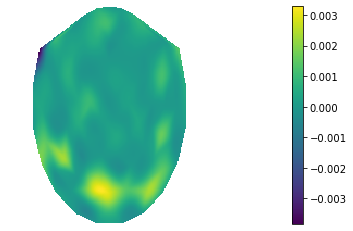

In [17]:
# Visualize the 204 * 1 weights for Imaginary Dataset
show_chanWeights(weights_img)

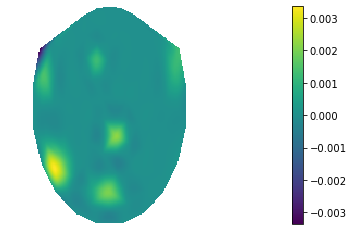

In [18]:
# Visualize the 204 * 1 weights for Overt Dataset
show_chanWeights(weights_overt)

In [19]:
# a = np.copy(ds_img[0, :])
# y = np.zeros(40)
# y[0:20] = -1
# y[20:40] = +1
# b = np.hstack((y.reshape(40, 1), a.reshape(40, 1)))
# print(a.shape)
# print(b.shape)
# print(b)

In [20]:
def divide_labels (arr_data) :
    alldat = np.copy(arr_data)
    dat_zero = alldat[alldat[:,0]==(-1), :]
    dat_one = alldat[alldat[:,0]==1, :]
    return dat_zero, dat_one

def compute_PFA (H0, thres) :
    H0_ds = np.sort(H0[:, 1])
    false_alarm = float(len(H0_ds[H0_ds >= thres])) / (H0.shape[0])
    return false_alarm

def compute_PD (H1, thres) :
    H1_ds = np.sort(H1[:, 1])
    detection = float(len(H1_ds[H1_ds >= thres])) / (H1.shape[0])
    return detection

In [21]:
def flex_thresholds (arr_data, flex_type) :
    alldata = np.copy(arr_data)
    if flex_type == 1 :
        thres = np.zeros(2 + alldata.shape[0])
        thres[1:-1] = np.sort(alldata[:, 1])
        thres[0] = float("-inf")
        thres[-1] = float("inf")
    return thres

def compute_ROC (arr_data, flex_type = 1) :
    arr_thres = flex_thresholds(arr_data, flex_type = 1)
    arr_PD = np.zeros(len(arr_thres))
    arr_PFA = np.zeros(len(arr_thres))
    H0, H1 = divide_labels(arr_data)
    for i in range(len(arr_thres)) :
        arr_PD[i] = compute_PD(H1, arr_thres[i])
        arr_PFA[i] = compute_PFA(H0, arr_thres[i])
    return np.flipud(arr_PD), np.flipud(arr_PFA)

In [22]:
def plot_ROC (svm_ds) :
    y = np.zeros(40)
    y[0:20] = -1 
    y[20:40] = +1 
    total_cv_ds = svm_ds.flatten()
    total_cv_y = np.concatenate((y, y, y, y, y, y))
    arr_data1 = np.hstack((y.reshape(40, 1), svm_ds[0, :].reshape(40, 1)))
    arr_data2 = np.hstack((y.reshape(40, 1), svm_ds[1, :].reshape(40, 1)))
    arr_data3 = np.hstack((y.reshape(40, 1), svm_ds[2, :].reshape(40, 1)))
    arr_data4 = np.hstack((y.reshape(40, 1), svm_ds[3, :].reshape(40, 1)))
    arr_data5 = np.hstack((y.reshape(40, 1), svm_ds[4, :].reshape(40, 1)))
    arr_data6 = np.hstack((y.reshape(40, 1), svm_ds[5, :].reshape(40, 1)))
    arr_data7 = np.hstack((total_cv_y.reshape(240, 1), total_cv_ds.reshape(240, 1)))
    s1_pd, s1_pfa = compute_ROC(arr_data1)
    s2_pd, s2_pfa = compute_ROC(arr_data2)
    s3_pd, s3_pfa = compute_ROC(arr_data3)
    s4_pd, s4_pfa = compute_ROC(arr_data4)
    s5_pd, s5_pfa = compute_ROC(arr_data5)
    s6_pd, s6_pfa = compute_ROC(arr_data6)
    s7_pd, s7_pfa = compute_ROC(arr_data7)
    auc1 = metrics.auc(s1_pfa, s1_pd)
    auc2 = metrics.auc(s2_pfa, s2_pd)
    auc3 = metrics.auc(s3_pfa, s3_pd)
    auc4 = metrics.auc(s4_pfa, s4_pd)
    auc5 = metrics.auc(s5_pfa, s5_pd)
    auc6 = metrics.auc(s6_pfa, s6_pd)
    auc7 = metrics.auc(s7_pfa, s7_pd)
    refln = np.linspace(0, 1, num = 101)
    figure, axis = plt.subplots()
    axis.plot(s1_pfa, s1_pd, label = "Fold #1 (AUC = %.3f)" % auc1, linewidth = 10)
    axis.plot(s2_pfa, s2_pd, label = "Fold #2 (AUC = %.3f)" % auc2, linewidth = 9)
    axis.plot(s3_pfa, s3_pd, label = "Fold #3 (AUC = %.3f)" % auc3, linewidth = 8)
    axis.plot(s4_pfa, s4_pd, label = "Fold #4 (AUC = %.3f)" % auc4, linewidth = 7)
    axis.plot(s5_pfa, s5_pd, label = "Fold #5 (AUC = %.3f)" % auc5, linewidth = 6)
    axis.plot(s6_pfa, s6_pd, label = "Fold #6 (AUC = %.3f)" % auc6, linewidth = 5)
    axis.plot(s7_pfa, s7_pd, label = "Total CV (AUC = %.3f)" % auc7, linewidth = 5)
    axis.plot(refln, refln, "--", label = "Chance Diagonal", linewidth = 3)
    axis.set_xlabel("PFA", fontsize = 15)
    axis.set_ylabel("PD", fontsize = 15)
    axis.set_title("ROC Curve", fontsize = 15)
    axis.grid()
    figure.set_size_inches(8, 6)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend(fontsize = 12)
    plt.show()
    return None

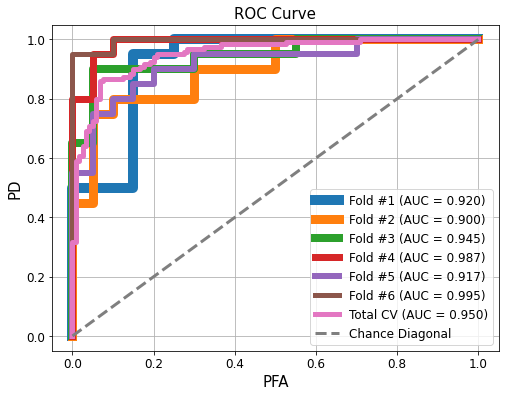

In [23]:
# Imaginary Dataset
# Provide the ROC for each 1st-level cross-validation fold (6 ROCs), 
# and the total cross-validated ROC on a single graph.
plot_ROC(ds_img)

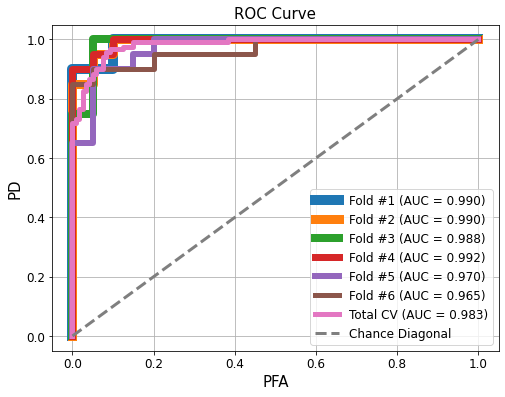

In [24]:
# Overt Dataset
# Provide the ROC for each 1st-level cross-validation fold (6 ROCs), 
# and the total cross-validated ROC on a single graph.
plot_ROC(ds_overt)